In [ ]:
import tensorflow as tf
from tensorflow import keras 
from keras.layers import Dense,Conv2D,Conv2DTranspose,MaxPool2D,LeakyReLU,BatchNormalization,Reshape,Flatten,Dropout
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.datasets import mnist
import time
from keras.losses import BinaryCrossentropy

In [ ]:
(train_images,train_labels),(test_images,test_labels)=mnist.load_data()


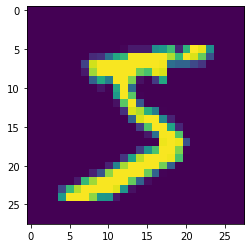

In [ ]:
plt.imshow(train_images[0])

In [ ]:
train_images=train_images.reshape(60000,28,28,1).astype("float32")
#Normalizing the images between[-1,1]
train_images=(train_images-127.5)/127.5


In [ ]:
train_images.shape

(60000, 28, 28, 1)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)


In [ ]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [ ]:
def make_generator():
  Generator=Sequential(name="Generator")
  
  #Layer 1 for generator
  Generator.add(Dense(7*7*256,use_bias=False,input_shape=(100,)))
  Generator.add(BatchNormalization(momentum=0.9))
  Generator.add(LeakyReLU())

  #layer 2 for generator
  Generator.add(Reshape((7,7,256)))
  Generator.add(Conv2DTranspose(128,kernel_size=(5,5),strides=(1,1),padding="same",use_bias=False))
  Generator.add(BatchNormalization())
  Generator.add(LeakyReLU())

  #Layer 3 for generator
  Generator.add(Conv2DTranspose(128,kernel_size=(5,5),strides=(2,2),padding="same",use_bias=False))
  Generator.add(BatchNormalization())
  Generator.add(LeakyReLU())

  #Output layer
  Generator.add(Conv2DTranspose(1,kernel_size=(5,5),strides=(2,2),padding="same",use_bias=False,activation="tanh"))

  return Generator

In [ ]:
def make_Discriminator():
  Discriminator=Sequential()

  #Layer1 for Discriminator
  Discriminator.add(Conv2D(64,(5,5),strides=(2,2),input_shape=(28,28,1)))
  Discriminator.add(LeakyReLU())
  Discriminator.add(Dropout(0.3))

  #Layer2 for Discriminator
  Discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  Discriminator.add(LeakyReLU())
  Discriminator.add(Dropout(0.3))

  #Layer3 for Discriminator
  Discriminator.add(Flatten())
  Discriminator.add(Dense(1))

  return Discriminator

In [ ]:
loss=BinaryCrossentropy(from_logits=True)

In [ ]:
def Discriminator_loss(real_op,fake_op):
  real_loss = loss(tf.ones_like(real_op),real_op)
  fake_loss = loss(tf.zeros_like(fake_op),fake_op)
  total_loss = fake_loss + real_loss
  return total_loss

def generator_loss(fake_op):
  fake_loss = loss(tf.ones_like(fake_op),fake_op)
  return fake_loss

In [ ]:
generator_optimizer=tf.keras.optimizers.Adam(3e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(3e-4)

In [ ]:
generator=make_generator()
discriminator=make_Discriminator()

In [ ]:
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0 

In [ ]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 12, 12, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

In [ ]:
NOISE_DIM=100
N_SAMPLES=16
seed = tf.random.normal([N_SAMPLES, NOISE_DIM])


In [ ]:
from PIL import Image as im
def train_step(image,plot_image=True,index=-1):
  noise = tf.random.normal([256, NOISE_DIM])

  with tf.GradientTape() as generator_tape,tf.GradientTape() as disc_tape:
    generated_images=generator(noise,training=True)

    real_op=discriminator(image,training=True)
    fake_op=discriminator(generated_images,training=True)

    gen_loss=generator_loss(fake_op)
    disc_loss=Discriminator_loss(real_op,fake_op)

    # plt.imshow(generated_images[0].numpy().reshape(28,28))
    if plot_image==True:
      # data=im.fromarray(generated_images[0].numpy().reshape(28,28))
      # data.save(str(index)+".png")
      print("Here")
      plt.imshow(generated_images[0].numpy().reshape(28,28))
  gradient_of_gen=generator_tape.gradient(gen_loss,generator.trainable_variables)
  gradient_of_disc=disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradient_of_disc,discriminator.trainable_variables))
  generator_optimizer.apply_gradients(zip(gradient_of_gen,generator.trainable_variables))

In [ ]:
def train_GAN(dataset, epochs):
  j=0
  for epoch in range(epochs):
    print(epoch)
    start = time.time()
    print(start)
    i=0
    
    for image_batch in dataset:
      plot_or_not=False
      i=i+1
      if i%100 == 0:
        j=j+1
        plot_or_not=True
        train_step(image_batch,plot_or_not,j)
      else:
        train_step(image_batch,plot_or_not)
      # print(f"\t{i}")
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

0
1621271912.838743
Here
Here
Time for epoch 1 is 26.671130895614624 sec
1
1621271939.5100317
Here
Here
Time for epoch 2 is 24.780323266983032 sec
2
1621271964.2908964
Here
Here
Time for epoch 3 is 24.697177171707153 sec
3
1621271988.9882162
Here
Here
Time for epoch 4 is 24.354066371917725 sec
4
1621272013.3429837
Here
Here
Time for epoch 5 is 24.441967010498047 sec


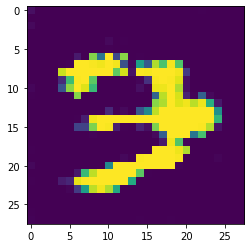

In [ ]:
train_GAN(train_dataset, 5)


In [ ]:
noise = tf.random.normal([256, NOISE_DIM])
gen_image=generator(noise,training=False)

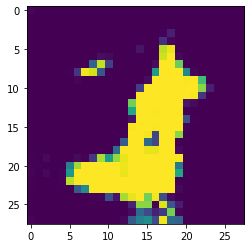

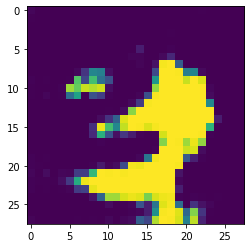

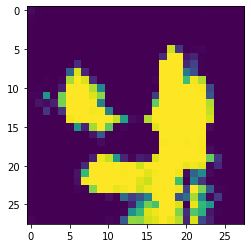

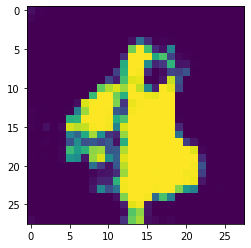

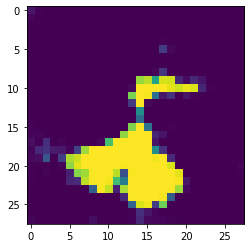

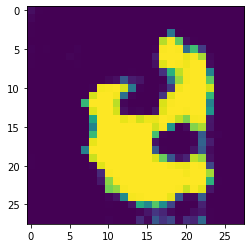

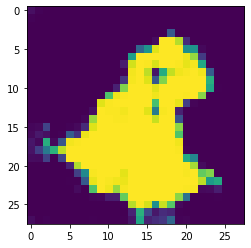

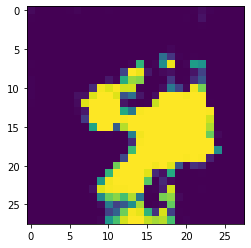

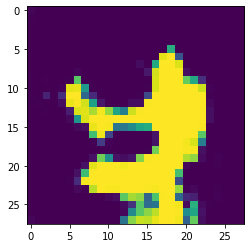

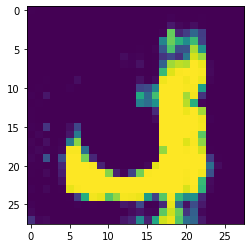

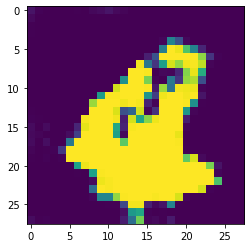

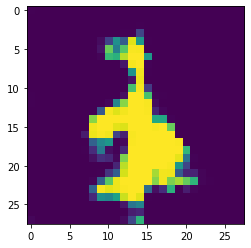

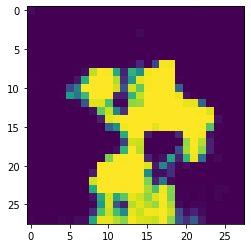

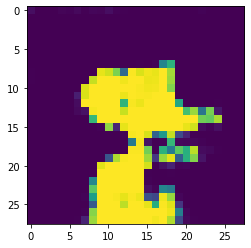

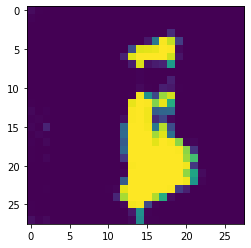

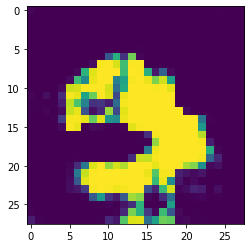

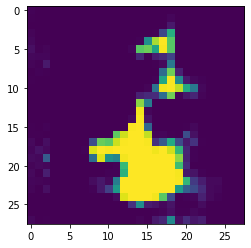

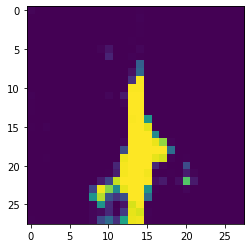

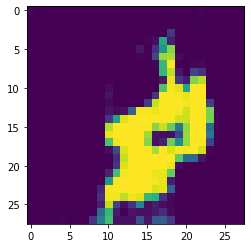

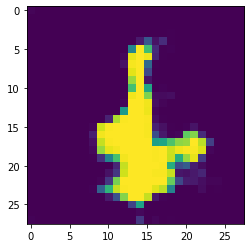

In [ ]:
for i in range(20):
  plt.imshow(gen_image[i].numpy().reshape(28,28))
  plt.show()
  time.sleep(5)